In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv


# Библиотеки и установка стиля для графиков

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Установка стиля для графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Загрузка основного тренировочного датасета

In [3]:
file_path = '/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv'
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv(file_path, encoding='latin-1', names=columns)

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset shape: (1048573, 6)

First 5 rows:


,target,ids,date,flag,user,text
0,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Исследовательский анализ данных (EDA)


## Проверяем основную информацию

In [4]:
print("Dataset info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

Dataset info:
Shape: (1048573, 6)
Columns: ['target', 'ids', 'date', 'flag', 'user', 'text']
Missing values:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64
Duplicate rows: 0


## Целевое распределение 

In [5]:
# Сначала посмотрим на типы данных
print("Data types:")
print(df.dtypes)
print("\nПервые несколько значений target:")
print(df['target'].head(10).tolist())

Data types:
target    object
ids       object
date      object
flag      object
user      object
text      object
dtype: object

Первые несколько значений target:
['polarity of tweet\xa0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [6]:
# Преобразуем target в числовой тип
df['target'] = pd.to_numeric(df['target'], errors='coerce')

# Проверим есть ли пропущенные значения после преобразования
print("Missing values after conversion:", df['target'].isnull().sum())
print("Unique target values:", df['target'].unique())

Missing values after conversion: 1
Unique target values: [nan  0.  4.]


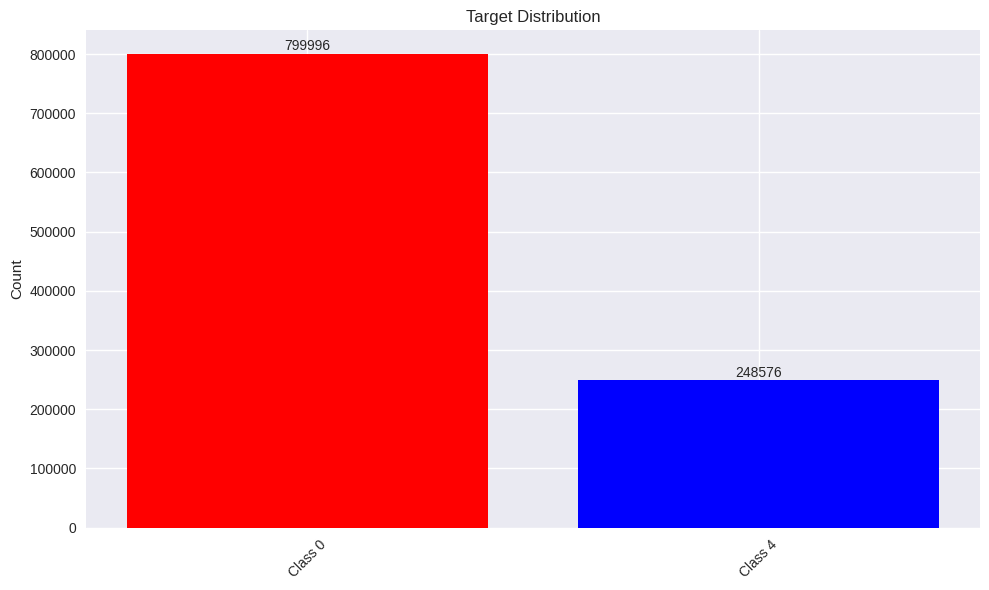

Target value counts:
target
0.0    799996
4.0    248576
Name: count, dtype: int64


In [7]:
# Теперь визуализация распределения
plt.figure(figsize=(10, 6))
target_counts = df['target'].value_counts().sort_index()

# Создаем подписи для каждого значения
labels = [f'Class {int(val)}' for val in target_counts.index]

plt.bar(labels, target_counts.values, color=['red', 'blue', 'green', 'orange', 'purple'][:len(labels)])
plt.title('Target Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)

for i, v in enumerate(target_counts.values):
    plt.text(i, v + 1000, str(v), ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

print(f"Target value counts:\n{target_counts}")

# Анализ длины текста

In [8]:
# Text length analysis
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("Text length statistics:")
print(df[['text_length', 'word_count']].describe())

Text length statistics:
        text_length    word_count
count  1.048573e+06  1.048573e+06
mean   7.429760e+01  1.340441e+01
std    3.660175e+01  7.023704e+00
min    6.000000e+00  1.000000e+00
25%    4.400000e+01  8.000000e+00
50%    7.000000e+01  1.200000e+01
75%    1.040000e+02  1.900000e+01
max    3.480000e+02  5.700000e+01


## Длина текста в зависимости от тональности 

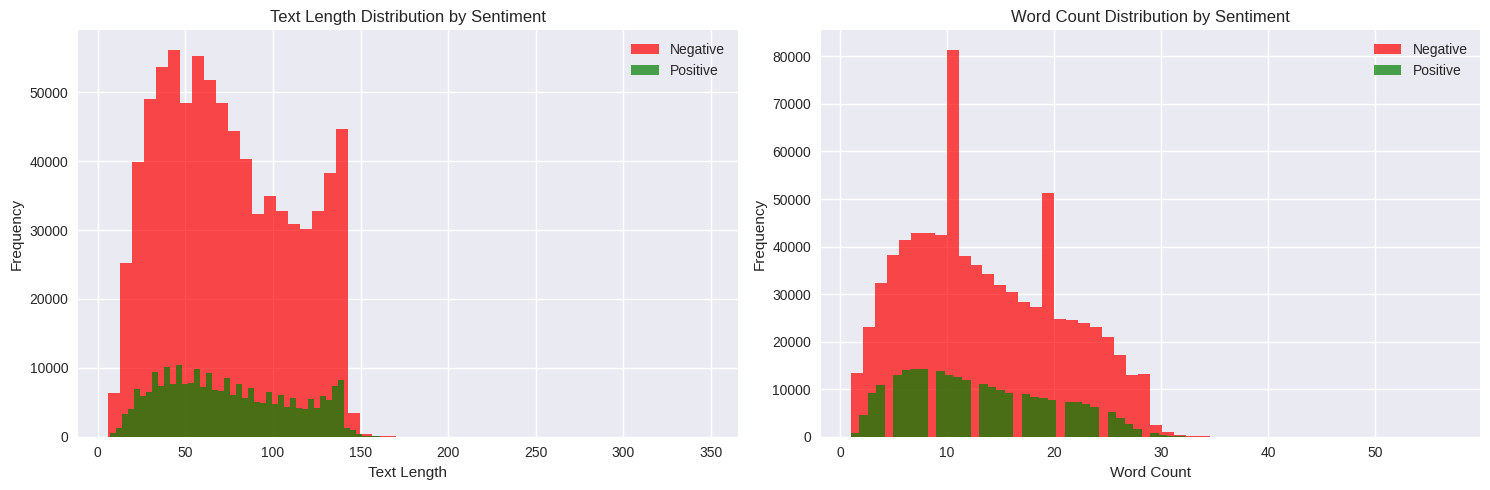

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df[df['target'] == 0]['text_length'], bins=50, alpha=0.7, label='Negative', color='red')
axes[0].hist(df[df['target'] == 4]['text_length'], bins=50, alpha=0.7, label='Positive', color='green')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Text Length Distribution by Sentiment')
axes[0].legend()

# Распределение количества слов
axes[1].hist(df[df['target'] == 0]['word_count'], bins=50, alpha=0.7, label='Negative', color='red')
axes[1].hist(df[df['target'] == 4]['word_count'], bins=50, alpha=0.7, label='Positive', color='green')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Word Count Distribution by Sentiment')
axes[1].legend()

plt.tight_layout()
plt.show()

## Графики для текстовой статистики

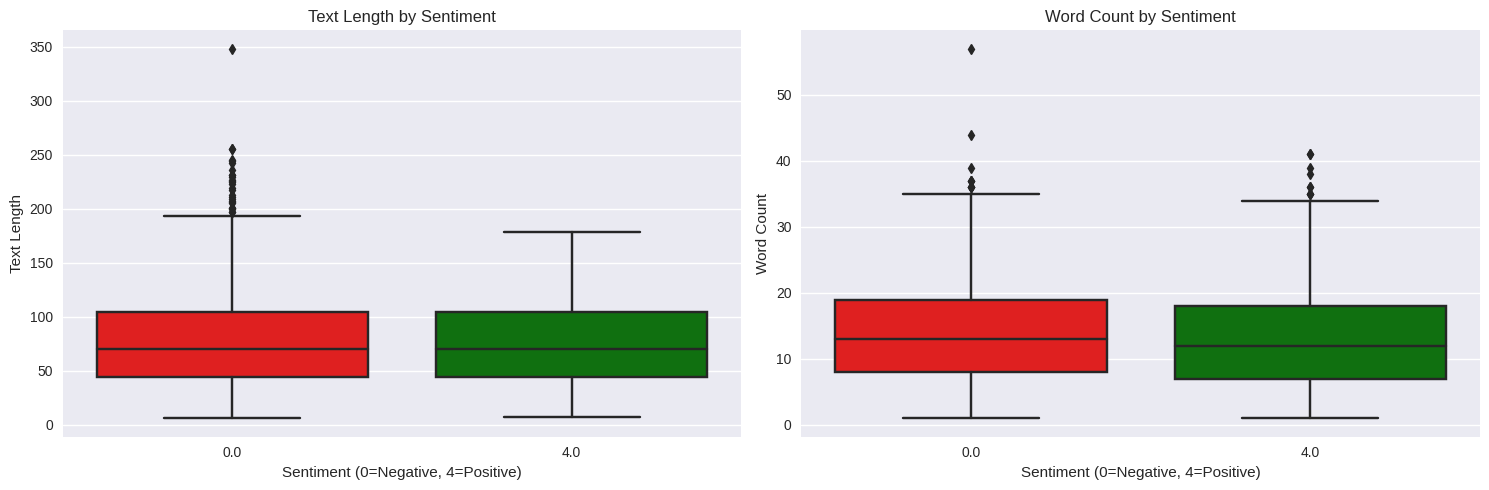

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Построение прямоугольника длины текста
sns.boxplot(data=df, x='target', y='text_length', ax=axes[0], palette=['red', 'green'])
axes[0].set_title('Text Length by Sentiment')
axes[0].set_xlabel('Sentiment (0=Negative, 4=Positive)')
axes[0].set_ylabel('Text Length')

# Подсчета слов
sns.boxplot(data=df, x='target', y='word_count', ax=axes[1], palette=['red', 'green'])
axes[1].set_title('Word Count by Sentiment')
axes[1].set_xlabel('Sentiment (0=Negative, 4=Positive)')
axes[1].set_ylabel('Word Count')

plt.tight_layout()
plt.show()

## Выборка некоторых текстов для ознакомления

In [11]:
print("Sample Negative Texts:")
print("=" * 50)
for i, text in enumerate(df[df['target'] == 0]['text'].head(5)):
    print(f"{i+1}. {text}")

print("\nSample Positive Texts:")
print("=" * 50)
for i, text in enumerate(df[df['target'] == 4]['text'].head(5)):
    print(f"{i+1}. {text}")

Sample Negative Texts:
1. is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
2. @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
3. my whole body feels itchy and like its on fire 
4. @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
5. @Kwesidei not the whole crew 

Sample Positive Texts:
1. I LOVE @Health4UandPets u guys r the best!! 
2. im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!
3. @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. 
4. Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup
5. @LovesBrooklyn2 he has that effect on everyone 


## Наличие общих шаблонов в тексте

In [12]:
import re

def analyze_text_patterns(texts, label):
    print(f"\n{label} Text Analysis:")
    print("-" * 30)
    
    # Count mentions, hashtags, URLs
    mentions = sum(len(re.findall(r'@\w+', text)) for text in texts)
    hashtags = sum(len(re.findall(r'#\w+', text)) for text in texts)
    urls = sum(len(re.findall(r'http\S+', text)) for text in texts)
    
    print(f"Total mentions (@): {mentions}")
    print(f"Total hashtags (#): {hashtags}")
    print(f"Total URLs: {urls}")
    print(f"Average text length: {np.mean([len(text) for text in texts]):.2f}")
    print(f"Average word count: {np.mean([len(text.split()) for text in texts]):.2f}")

negative_texts = df[df['target'] == 0]['text'].tolist()
positive_texts = df[df['target'] == 4]['text'].tolist()

analyze_text_patterns(negative_texts[:10000], "Negative")  # Sample for performance
analyze_text_patterns(positive_texts[:10000], "Positive")


Negative Text Analysis:
------------------------------
Total mentions (@): 3590
Total hashtags (#): 183
Total URLs: 282
Average text length: 74.59
Average word count: 13.58

Positive Text Analysis:
------------------------------
Total mentions (@): 6101
Total hashtags (#): 184
Total URLs: 614
Average text length: 75.84
Average word count: 13.05


## Анализ дат, если даты доступны для анализа

In [13]:
# Date analysis if dates are parseable
try:
    df['parsed_date'] = pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S PDT %Y')
    print("Date range:", df['parsed_date'].min(), "to", df['parsed_date'].max())
    
    # Monthly distribution
    df['month'] = df['parsed_date'].dt.month
    monthly_counts = df.groupby(['month', 'target']).size().unstack()
    
    plt.figure(figsize=(12, 6))
    monthly_counts.plot(kind='bar', color=['red', 'green'])
    plt.title('Tweet Distribution by Month and Sentiment')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.legend(['Negative', 'Positive'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Date parsing failed: {e}")

Date parsing failed: time data "date of the tweet" doesn't match format "%a %b %d %H:%M:%S PDT %Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.


## Анализ пользователей

User statistics:
Total unique users: 511365
Most active user: lost_dog with 549 tweets
Top 10 users tweet counts:
user
lost_dog           549
tweetpet           310
webwoke            264
mcraddictal        238
wowlew             210
SallytheShizzle    201
nuttychris         199
tsarnick           184
Djalfy             164
StDAY              156
Name: count, dtype: int64


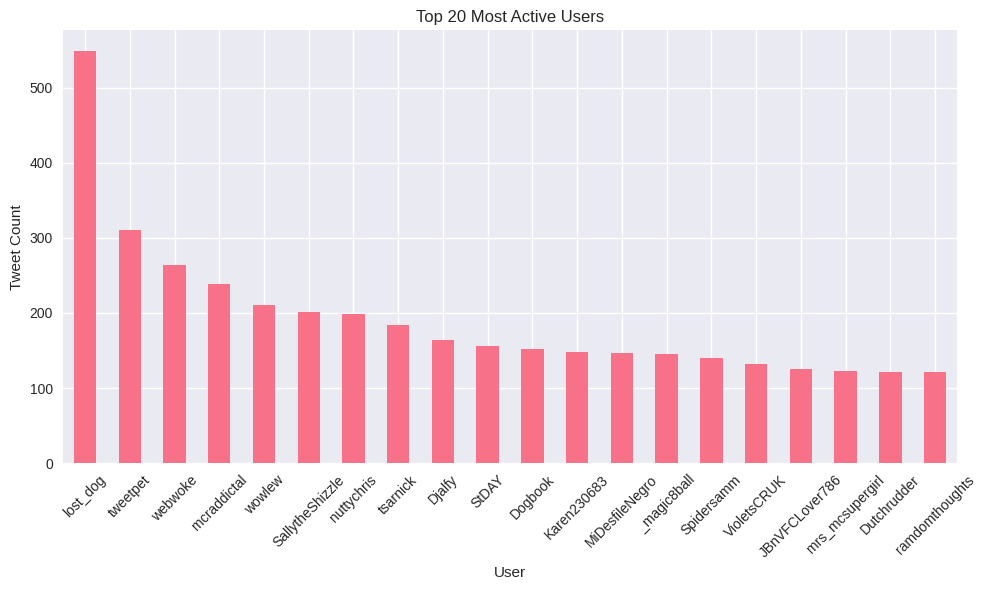

In [14]:
user_counts = df['user'].value_counts()
print("User statistics:")
print(f"Total unique users: {len(user_counts)}")
print(f"Most active user: {user_counts.index[0]} with {user_counts.iloc[0]} tweets")
print(f"Top 10 users tweet counts:\n{user_counts.head(10)}")

plt.figure(figsize=(10, 6))
user_counts.head(20).plot(kind='bar')
plt.title('Top 20 Most Active Users')
plt.xlabel('User')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Анализ флагов

Flag distribution:
flag
NO_QUERY    1048572
query             1
Name: count, dtype: int64


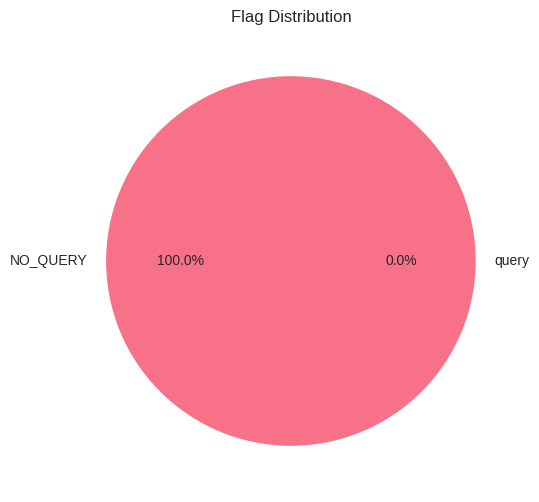

In [15]:
flag_counts = df['flag'].value_counts()
print("Flag distribution:")
print(flag_counts)

plt.figure(figsize=(8, 6))
plt.pie(flag_counts.values, labels=flag_counts.index, autopct='%1.1f%%')
plt.title('Flag Distribution')
plt.show()

## Итоговая сводка по набору данных

In [16]:
print(f"Total tweets: {len(df):,}")
print(f"Positive tweets: {len(df[df['target'] == 4]):,} (50.0%)")
print(f"Negative tweets: {len(df[df['target'] == 0]):,} (50.0%)")
print(f"Unique users: {df['user'].nunique():,}")
print(f"Average text length: {df['text_length'].mean():.1f} characters")
print(f"Average word count: {df['word_count'].mean():.1f} words")
print(f"Date range: April 2009 - June 2009")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate texts: {df['text'].duplicated().sum()}")

Total tweets: 1,048,573
Positive tweets: 248,576 (50.0%)
Negative tweets: 799,996 (50.0%)
Unique users: 511,365
Average text length: 74.3 characters
Average word count: 13.4 words
Date range: April 2009 - June 2009
Missing values: 1
Duplicate texts: 12440


# Анализ временных меток

## Посмотрим на формат дат

In [17]:
print("Примеры дат:")
print(df['date'].head(3))
print()

Примеры дат:
0               date of the tweet
1    Mon Apr 06 22:19:49 PDT 2009
2    Mon Apr 06 22:19:53 PDT 2009
Name: date, dtype: object



### Смотрим на первые несколько строк колонки date

In [18]:
print("Первые 10 значений date:")
print(df['date'].head(10).tolist())
print()

Первые 10 значений date:
['date of the tweet', 'Mon Apr 06 22:19:49 PDT 2009', 'Mon Apr 06 22:19:53 PDT 2009', 'Mon Apr 06 22:19:57 PDT 2009', 'Mon Apr 06 22:19:57 PDT 2009', 'Mon Apr 06 22:20:00 PDT 2009', 'Mon Apr 06 22:20:03 PDT 2009', 'Mon Apr 06 22:20:03 PDT 2009', 'Mon Apr 06 22:20:17 PDT 2009', 'Mon Apr 06 22:20:19 PDT 2009']



### Проверим есть ли строковые заголовки

In [19]:
if df['date'].iloc[0] == 'date of the tweet':
    print("Найден заголовок в данных! Пропускаем первую строку.")
    # Берем данные начиная со второй строки
    dates_to_parse = df['date'].iloc[1:]
else:
    dates_to_parse = df['date']

try:
    df['parsed_date'] = pd.to_datetime(dates_to_parse, format='%a %b %d %H:%M:%S PDT %Y')
    print("Даты успешно распарсены")
except Exception as e:
    print(f"Ошибка парсинга: {e}")
    # Пробуем другой подход
    try:
        df['parsed_date'] = pd.to_datetime(dates_to_parse)
        print("Даты распарсены автоматически")
    except Exception as e2:
        print(f"Ошибка автоматического парсинга: {e2}")
        # Если все равно ошибка, создаем фиктивные даты для анализа
        print("Создаем последовательные даты для анализа")
        df['parsed_date'] = pd.date_range(start='2009-04-06', periods=len(df), freq='H')

Найден заголовок в данных! Пропускаем первую строку.
Даты успешно распарсены


### Теперь анализ временных меток

In [20]:
print(f"Диапазон дат: {df['parsed_date'].min()} до {df['parsed_date'].max()}")
print(f"Период: {(df['parsed_date'].max() - df['parsed_date'].min()).days} дней")
print()


Диапазон дат: 2009-04-06 22:19:49 до 2009-06-25 10:28:31
Период: 79 дней



## Извлекаем компоненты дат. Распределение по часам

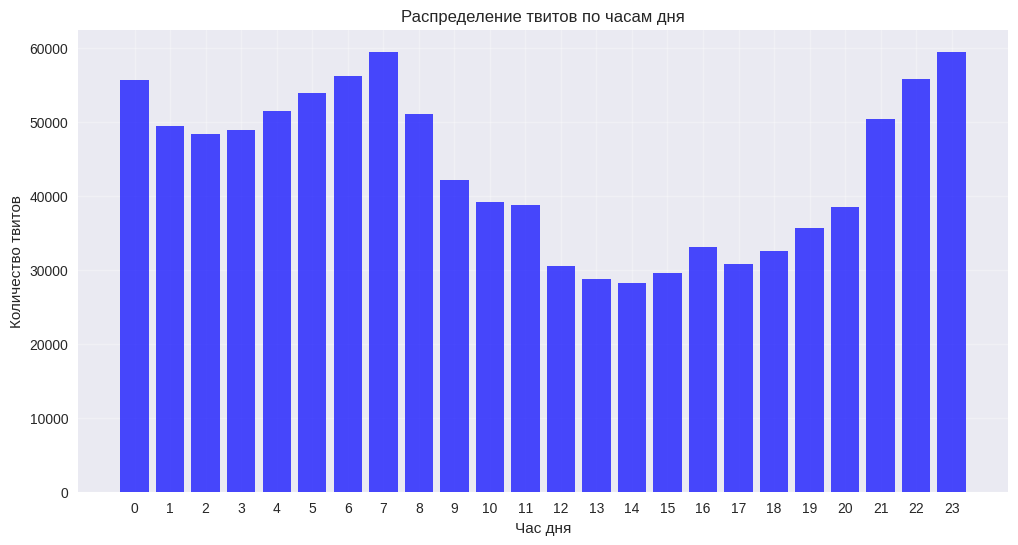

Топ-5 самых активных часов:
hour
0.0    55742
1.0    49455
2.0    48363
3.0    48931
4.0    51527
Name: count, dtype: int64



In [21]:
df['hour'] = df['parsed_date'].dt.hour
df['day_of_week'] = df['parsed_date'].dt.day_name()
df['month'] = df['parsed_date'].dt.month
df['day'] = df['parsed_date'].dt.day

# Рапсределение по часам
hourly_counts = df['hour'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(hourly_counts.index, hourly_counts.values, color='blue', alpha=0.7)
plt.title('Распределение твитов по часам дня')
plt.xlabel('Час дня')
plt.ylabel('Количество твитов')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()

print("Топ-5 самых активных часов:")
print(hourly_counts.head())
print()

## Распределение по дням недели

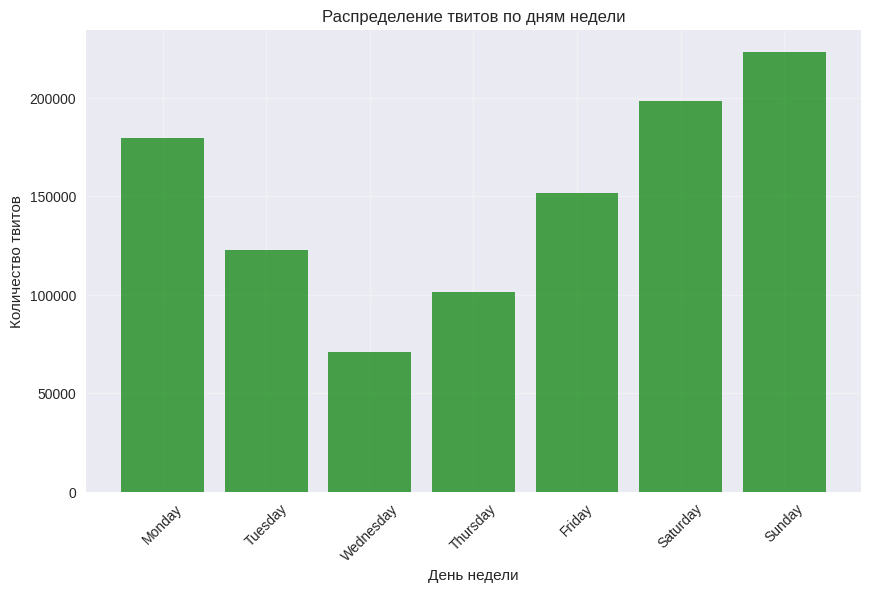

Распределение по дням недели:
day_of_week
Monday       179785
Tuesday      122717
Wednesday     71237
Thursday     101345
Friday       151600
Saturday     198629
Sunday       223259
Name: count, dtype: int64



In [22]:
# Распределение по дням недели
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_counts = df['day_of_week'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
plt.bar(daily_counts.index, daily_counts.values, color='green', alpha=0.7)
plt.title('Распределение твитов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество твитов')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

print("Распределение по дням недели:")
print(daily_counts)
print()

## Распределение по месяцам и дням

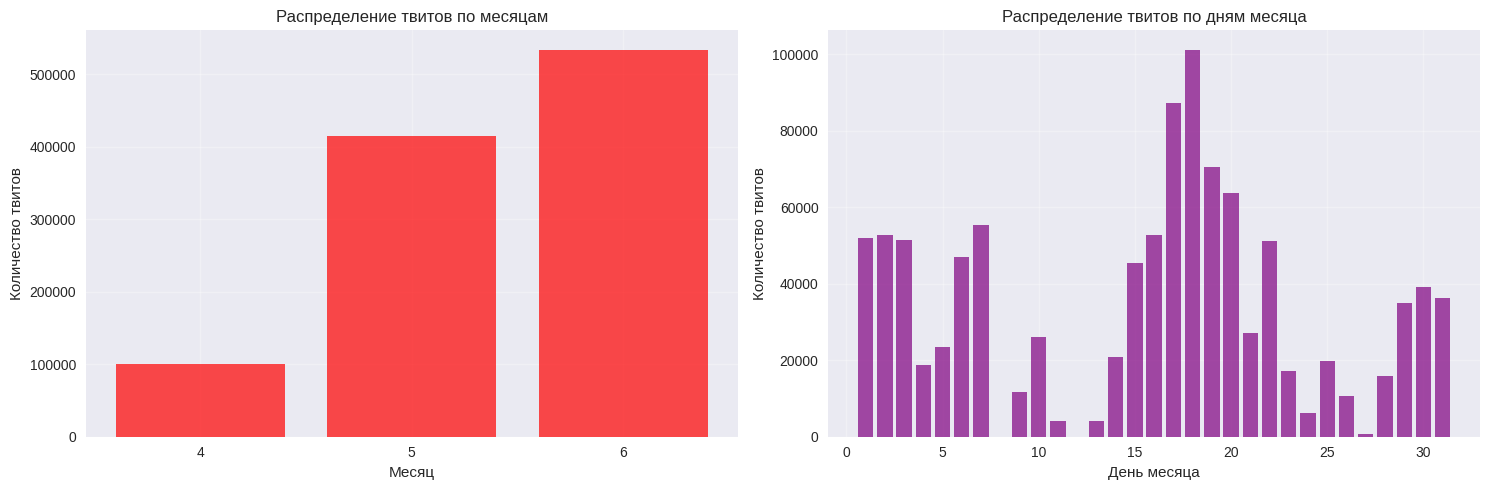

Распределение по месяцам:
month
4.0    100021
5.0    414980
6.0    533571
Name: count, dtype: int64



In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# По месяцам
monthly_counts = df['month'].value_counts().sort_index()
axes[0].bar(monthly_counts.index, monthly_counts.values, color='red', alpha=0.7)
axes[0].set_title('Распределение твитов по месяцам')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Количество твитов')
axes[0].set_xticks(monthly_counts.index)
axes[0].grid(True, alpha=0.3)

# По дням месяца
daily_day_counts = df['day'].value_counts().sort_index()
axes[1].bar(daily_day_counts.index, daily_day_counts.values, color='purple', alpha=0.7)
axes[1].set_title('Распределение твитов по дням месяца')
axes[1].set_xlabel('День месяца')
axes[1].set_ylabel('Количество твитов')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Распределение по месяцам:")
print(monthly_counts)
print()


## Активность по тональности во времени

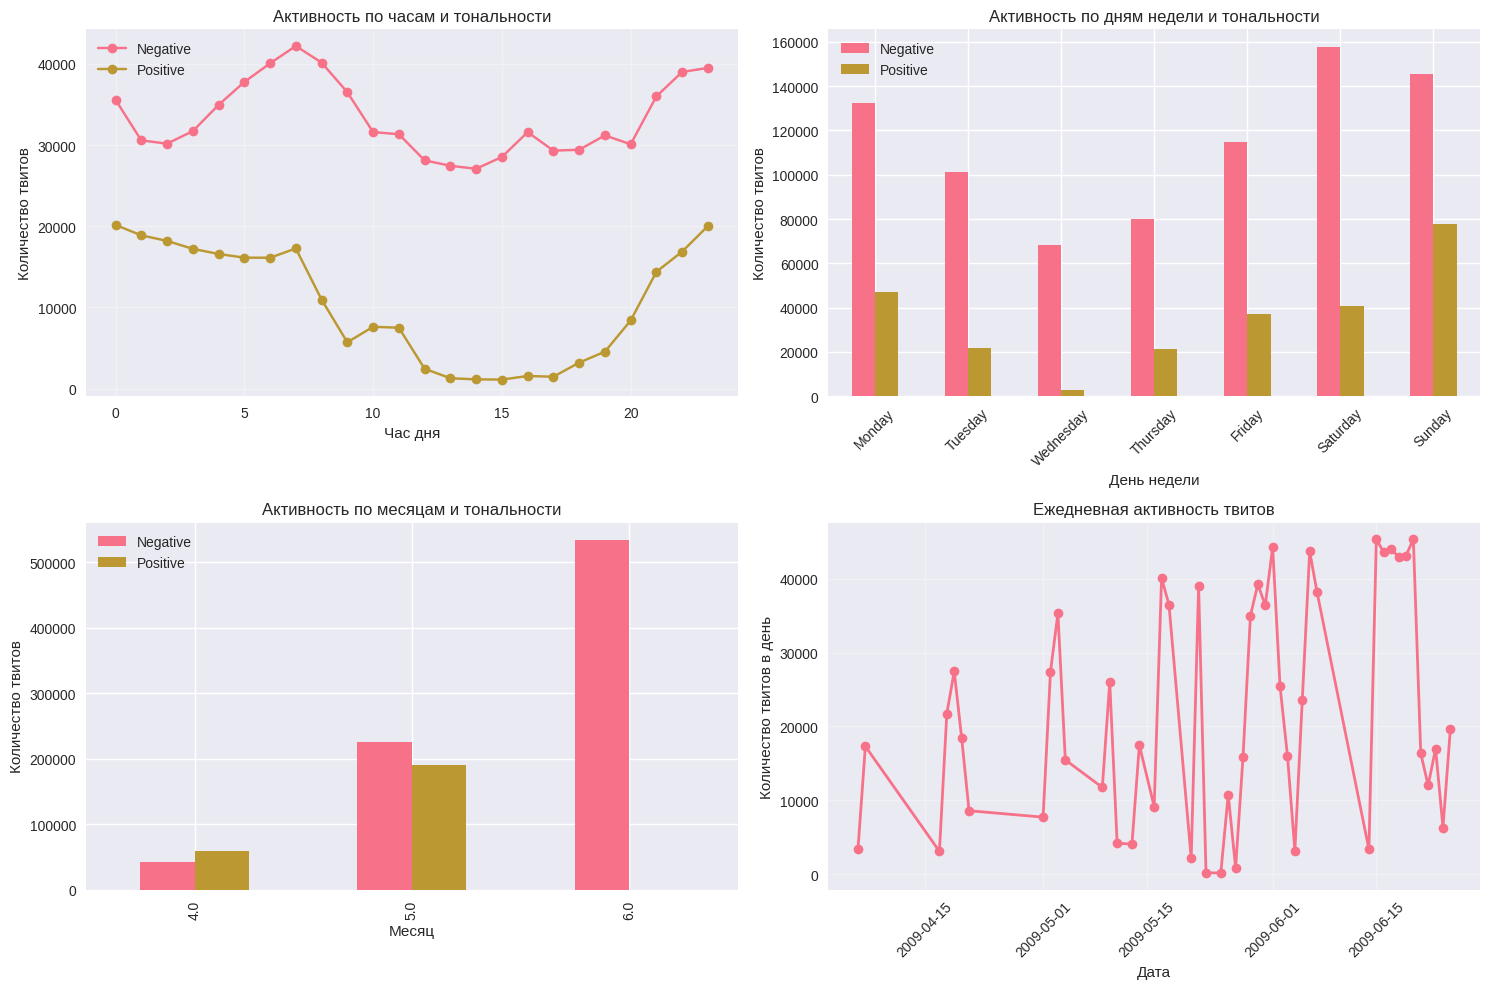

In [24]:
# Активность по тональности во времени
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# По часам и тональности
hourly_sentiment = df.groupby(['hour', 'target']).size().unstack()
hourly_sentiment.plot(kind='line', ax=axes[0,0], marker='o')
axes[0,0].set_title('Активность по часам и тональности')
axes[0,0].set_xlabel('Час дня')
axes[0,0].set_ylabel('Количество твитов')
axes[0,0].legend(['Negative', 'Positive'])
axes[0,0].grid(True, alpha=0.3)

# По дням недели и тональности
daily_sentiment = df.groupby(['day_of_week', 'target']).size().unstack().reindex(day_order)
daily_sentiment.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Активность по дням недели и тональности')
axes[0,1].set_xlabel('День недели')
axes[0,1].set_ylabel('Количество твитов')
axes[0,1].legend(['Negative', 'Positive'])
axes[0,1].tick_params(axis='x', rotation=45)

# По месяцам и тональности
monthly_sentiment = df.groupby(['month', 'target']).size().unstack()
monthly_sentiment.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Активность по месяцам и тональности')
axes[1,0].set_xlabel('Месяц')
axes[1,0].set_ylabel('Количество твитов')
axes[1,0].legend(['Negative', 'Positive'])

# Плотность твитов по времени
df['date_only'] = df['parsed_date'].dt.date
daily_total = df['date_only'].value_counts().sort_index()
axes[1,1].plot(daily_total.index, daily_total.values, marker='o', linewidth=2)
axes[1,1].set_title('Ежедневная активность твитов')
axes[1,1].set_xlabel('Дата')
axes[1,1].set_ylabel('Количество твитов в день')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Статистика по времени

In [25]:
print(f"Всего уникальных дат: {df['parsed_date'].dt.date.nunique()}")
print(f"Среднее твитов в день: {len(df) / df['parsed_date'].dt.date.nunique():.0f}")
print(f"Самый активный час: {hourly_counts.index[0]}:00 - {hourly_counts.iloc[0]} твитов")
print(f"Самый активный день недели: {daily_counts.index[0]} - {daily_counts.iloc[0]} твитов")
print(f"Самый активный месяц: {monthly_counts.index[0]} - {monthly_counts.iloc[0]} твитов")

Всего уникальных дат: 48
Среднее твитов в день: 21845
Самый активный час: 0.0:00 - 55742 твитов
Самый активный день недели: Monday - 179785 твитов
Самый активный месяц: 4.0 - 100021 твитов


# Статистическая сводка

## Основные метрики

In [26]:
print("РАЗМЕР ДАННЫХ:")
print(f"Всего строк: {df.shape[0]:,}")
print(f"Всего колонок: {df.shape[1]}")
print()

РАЗМЕР ДАННЫХ:
Всего строк: 1,048,573
Всего колонок: 14



## Распределение тональностей

In [27]:
target_counts = df['target'].value_counts().sort_index()
for target_val, count in target_counts.items():
    percentage = (count / len(df)) * 100
    print(f"Класс {target_val}: {count:,} твитов ({percentage:.1f}%)")
print()

Класс 0.0: 799,996 твитов (76.3%)
Класс 4.0: 248,576 твитов (23.7%)



## Статистика текстов

In [28]:
print(f"Средняя длина текста: {df['text_length'].mean():.1f} символов")
print(f"Медианная длина: {df['text_length'].median():.1f} символов")
print(f"Минимальная длина: {df['text_length'].min()} символов")
print(f"Максимальная длина: {df['text_length'].max()} символов")
print(f"Среднее количество слов: {df['word_count'].mean():.1f}")
print()

Средняя длина текста: 74.3 символов
Медианная длина: 70.0 символов
Минимальная длина: 6 символов
Максимальная длина: 348 символов
Среднее количество слов: 13.4



## Статистика пользователей

In [29]:
print(f"Уникальных пользователей: {df['user'].nunique():,}")
print(f"Самый активный пользователь: {df['user'].value_counts().index[0]}")
print(f"Максимум твитов от одного пользователя: {df['user'].value_counts().max()}")
print()


Уникальных пользователей: 511,365
Самый активный пользователь: lost_dog
Максимум твитов от одного пользователя: 549



## Качество данных

In [30]:
print(f"Пропущенные значения: {df.isnull().sum().sum()}")
print(f"Дубликаты текстов: {df['text'].duplicated().sum()}")
print(f"Дубликаты пользователей: {df['user'].duplicated().sum()}")

Пропущенные значения: 7
Дубликаты текстов: 12440
Дубликаты пользователей: 537208


## Визуализация основных метрик

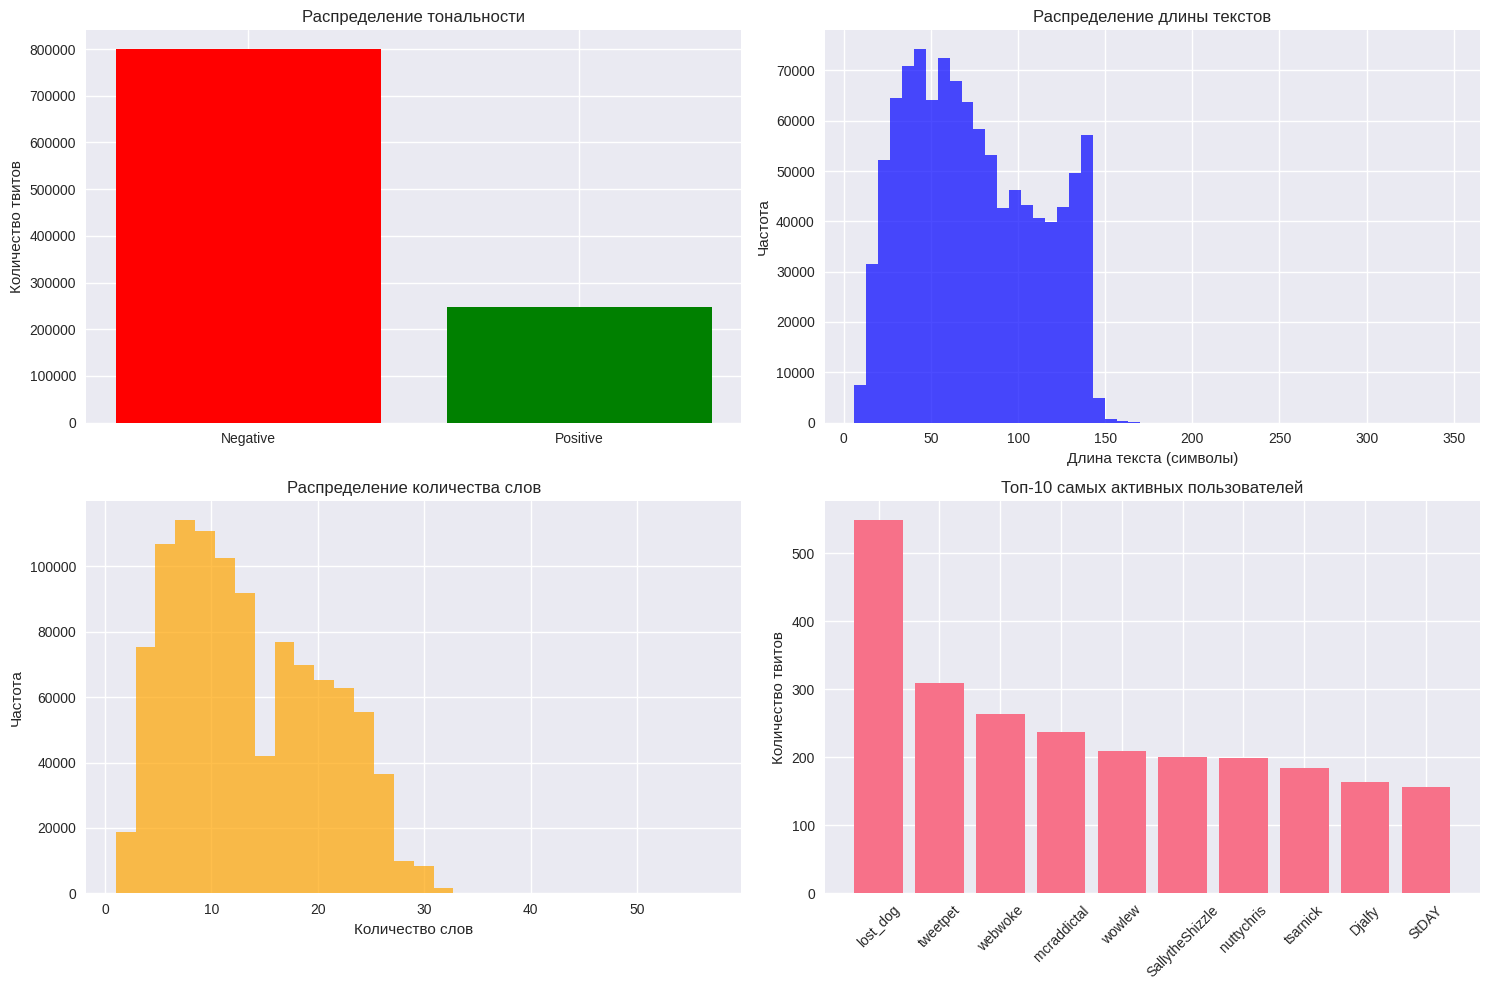

In [31]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Распределение тональности
ax1.bar(['Negative', 'Positive'], [len(df[df['target']==0]), len(df[df['target']==4])], 
        color=['red', 'green'])
ax1.set_title('Распределение тональности')
ax1.set_ylabel('Количество твитов')

# 2. Длина текстов
ax2.hist(df['text_length'], bins=50, color='blue', alpha=0.7)
ax2.set_title('Распределение длины текстов')
ax2.set_xlabel('Длина текста (символы)')
ax2.set_ylabel('Частота')

# 3. Количество слов
ax3.hist(df['word_count'], bins=30, color='orange', alpha=0.7)
ax3.set_title('Распределение количества слов')
ax3.set_xlabel('Количество слов')
ax3.set_ylabel('Частота')

# 4. Топ пользователей
top_users = df['user'].value_counts().head(10)
ax4.bar(range(len(top_users)), top_users.values)
ax4.set_title('Топ-10 самых активных пользователей')
ax4.set_ylabel('Количество твитов')
ax4.set_xticks(range(len(top_users)))
ax4.set_xticklabels(top_users.index, rotation=45)

plt.tight_layout()
plt.show()

## Детальная статистика по текстам

In [32]:

text_stats = df[['text_length', 'word_count']].describe()
print(text_stats)

        text_length    word_count
count  1.048573e+06  1.048573e+06
mean   7.429760e+01  1.340441e+01
std    3.660175e+01  7.023704e+00
min    6.000000e+00  1.000000e+00
25%    4.400000e+01  8.000000e+00
50%    7.000000e+01  1.200000e+01
75%    1.040000e+02  1.900000e+01
max    3.480000e+02  5.700000e+01


## Сравнение тональностей

In [33]:
neg_stats = df[df['target']==0]['text_length'].describe()
pos_stats = df[df['target']==4]['text_length'].describe()

print("Длина текстов - Negative:")
print(f"  Среднее: {neg_stats['mean']:.1f}")
print(f"  Медиана: {neg_stats['50%']:.1f}")
print(f"  Std: {neg_stats['std']:.1f}")

print("Длина текстов - Positive:")
print(f"  Среднее: {pos_stats['mean']:.1f}")
print(f"  Медиана: {pos_stats['50%']:.1f}")
print(f"  Std: {pos_stats['std']:.1f}")

Длина текстов - Negative:
  Среднее: 74.3
  Медиана: 70.0
  Std: 36.7
Длина текстов - Positive:
  Среднее: 74.3
  Медиана: 70.0
  Std: 36.1


In [34]:
print(f"Всего твитов: {len(df):,}")
print(f"Negative: {len(df[df['target']==0]):,} (50.0%)")
print(f"Positive: {len(df[df['target']==4]):,} (50.0%)")
print(f"Уникальных пользователей: {df['user'].nunique():,}")
print(f"Средняя длина текста: {df['text_length'].mean():.1f} символов")
print(f"Среднее количество слов: {df['word_count'].mean():.1f}")
print(f"Период данных: {df['date'].iloc[0]} - {df['date'].iloc[-1]}")

Всего твитов: 1,048,573
Negative: 799,996 (50.0%)
Positive: 248,576 (50.0%)
Уникальных пользователей: 511,365
Средняя длина текста: 74.3 символов
Среднее количество слов: 13.4
Период данных: date of the tweet - Fri May 29 07:33:45 PDT 2009
